In [1]:
import os
import sys
import math
import time
import numpy as np
import tensorflow as tf
from tqdm import tqdm, trange
from matplotlib import pyplot as plt
from tensorflow import keras as K
import glob

print("tf: {}".format(tf.version.VERSION))
print("tf.keras: {}".format(K.__version__))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

tf: 2.1.0
tf.keras: 2.2.4-tf
Num GPUs Available:  1


In [2]:
sys.path.append('../SketchRNN_tf2')
from sketchrnn import models, dataset, utils

In [3]:
def strokes_to_lines(sketch):
    X = []
    Y = []

    tmp_x, tmp_y = [], []
    sx = sy = 0
    for p in sketch:
        sx += p[0]
        sy += p[1]
        tmp_x.append(sx)
        tmp_y.append(-sy)
        if p[2] == 1:
            X.append(tmp_x)
            Y.append(tmp_y)
            tmp_x, tmp_y = [], []

    X.append(tmp_x)
    Y.append(tmp_y)

    return X, Y

def visualize(sketch):
    X, Y = strokes_to_lines(sketch)

    for x, y in zip(X, Y):
        plt.plot(x, y)

    # save the image.
    # plt.savefig("sample.png")

    # show the plot
    plt.axes().set_aspect('equal')
    plt.show()

In [4]:
def to_normal_strokes(big_stroke):
    """Convert from stroke-5 format (from sketch-rnn paper) back to stroke-3."""
    l = 0
    for i in range(len(big_stroke)):
        if big_stroke[i, 4] > 0:
            l = i
            break
    if l == 0:
        l = len(big_stroke)
    result = np.zeros((l, 3))
    result[:, 0:2] = big_stroke[0:l, 0:2]
    result[:, 2] = big_stroke[0:l, 3]
    return result


In [5]:

with open('../outputs/labels.txt', 'r') as f:
    classes = list(map(lambda s: s.strip(), f.readlines()))

Loaded Weights From: ../data/sketchrnn/airplane/checkpoints/sketch_rnn_airplane_weights.30_0.16.hdf5
data class: airplane
Loaded Weights From: ../data/sketchrnn/apple/checkpoints/sketch_rnn_apple_weights.30_0.17.hdf5
data class: apple
Loaded Weights From: ../data/sketchrnn/hot air balloon/checkpoints/sketch_rnn_hot air balloon_weights.30_0.13.hdf5
data class: hot air balloon
Loaded Weights From: ../data/sketchrnn/banana/checkpoints/sketch_rnn_banana_weights.30_0.11.hdf5
data class: banana
Loaded Weights From: ../data/sketchrnn/basket/checkpoints/sketch_rnn_basket_weights.30_-0.01.hdf5
data class: basket
Loaded Weights From: ../data/sketchrnn/bee/checkpoints/sketch_rnn_bee_weights.30_0.19.hdf5
data class: bee
Loaded Weights From: ../data/sketchrnn/bench/checkpoints/sketch_rnn_bench_weights.30_-0.01.hdf5
data class: bench
Loaded Weights From: ../data/sketchrnn/bicycle/checkpoints/sketch_rnn_bicycle_weights.30_0.02.hdf5
data class: bicycle
Loaded Weights From: ../data/sketchrnn/bird/check

/home/george/anaconda3/envs/i-sketcher/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Loaded Weights From: ../data/sketchrnn/fence/checkpoints/sketch_rnn_fence_weights.30_-0.11.hdf5
data class: fence
Loaded Weights From: ../data/sketchrnn/flower/checkpoints/sketch_rnn_flower_weights.30_0.26.hdf5
data class: flower
Loaded Weights From: ../data/sketchrnn/grapes/checkpoints/sketch_rnn_grapes_weights.30_0.12.hdf5
data class: grapes
Loaded Weights From: ../data/sketchrnn/grass/checkpoints/sketch_rnn_grass_weights.30_-0.02.hdf5
data class: grass
Loaded Weights From: ../data/sketchrnn/horse/checkpoints/sketch_rnn_horse_weights.30_0.31.hdf5
data class: horse
Loaded Weights From: ../data/sketchrnn/house/checkpoints/sketch_rnn_house_weights.30_0.04.hdf5
data class: house
Loaded Weights From: ../data/sketchrnn/moon/checkpoints/sketch_rnn_moon_weights.30_0.03.hdf5
data class: moon
Loaded Weights From: ../data/sketchrnn/mountain/checkpoints/sketch_rnn_mountain_weights.30_-0.16.hdf5
data class: mountain
Loaded Weights From: ../data/sketchrnn/face/checkpoints/sketch_rnn_face_weights.3

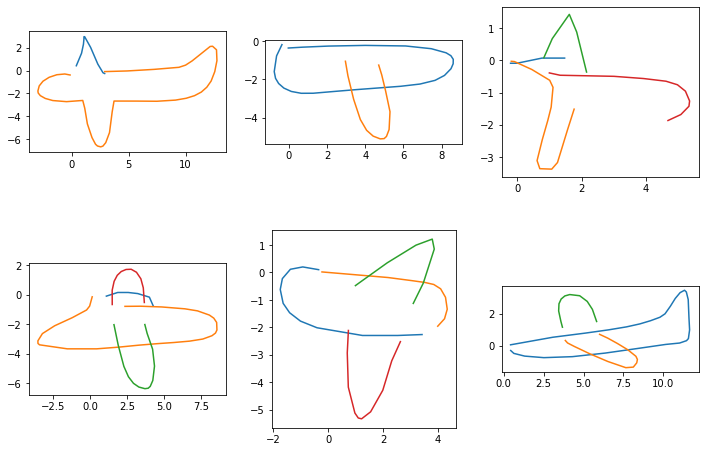

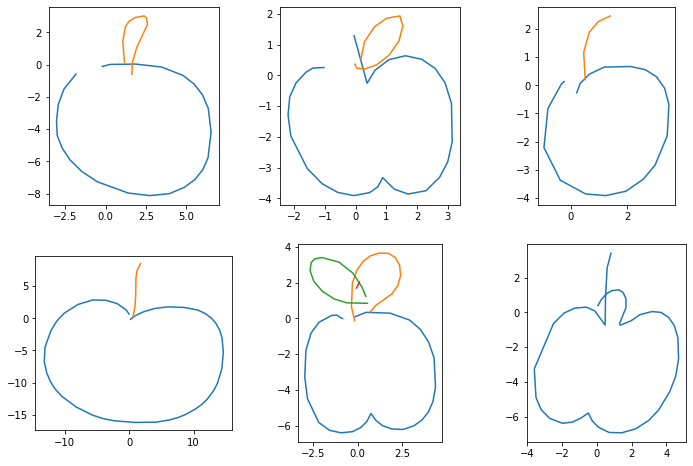

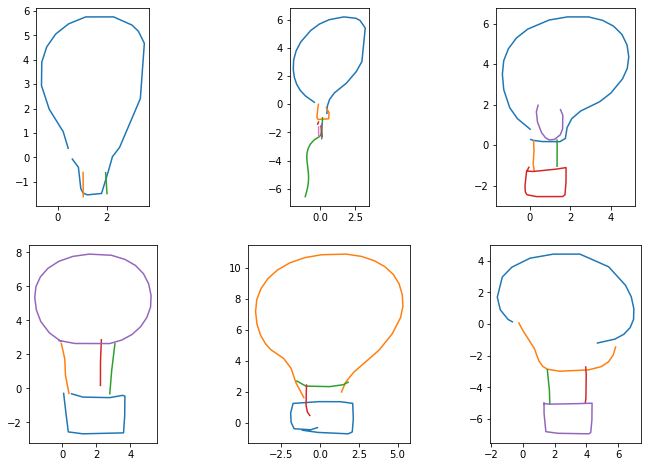

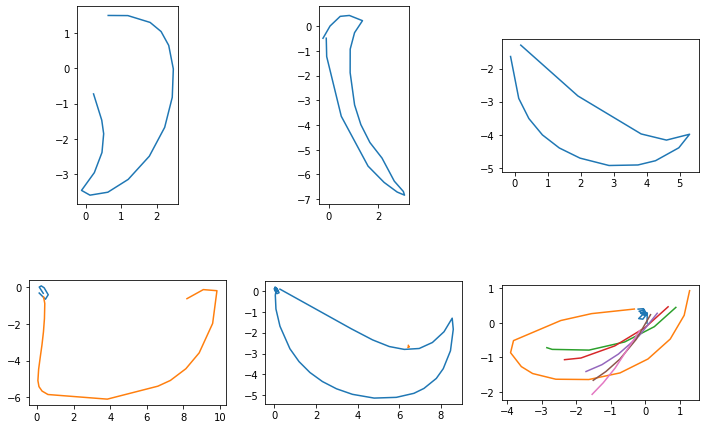

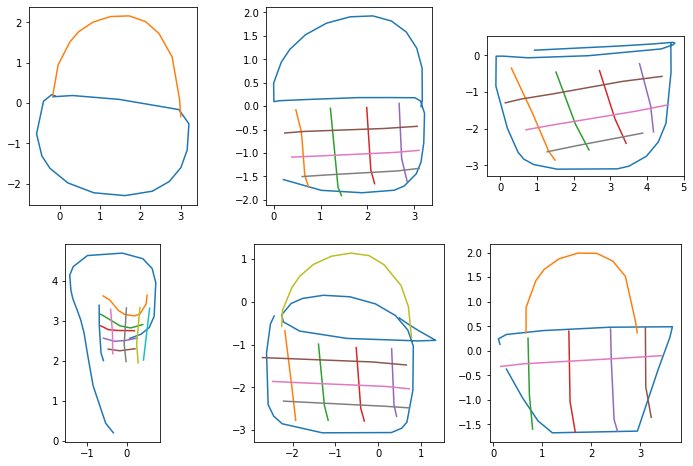

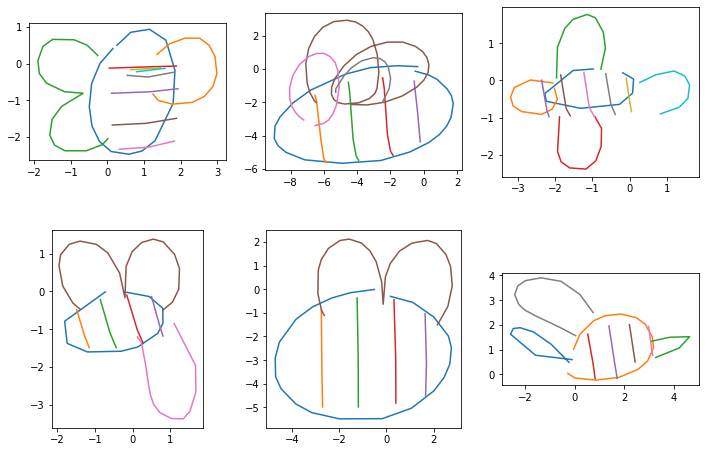

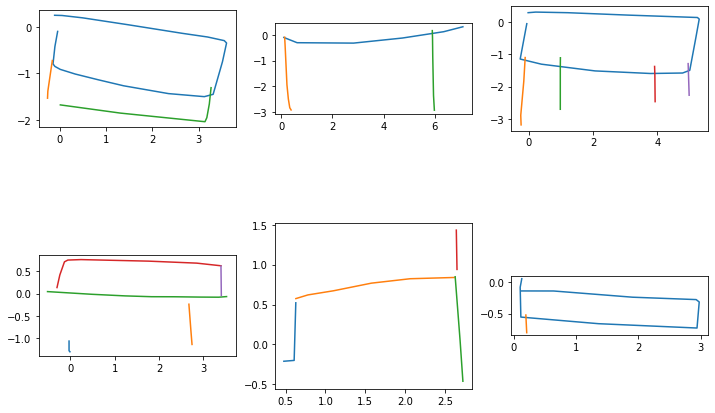

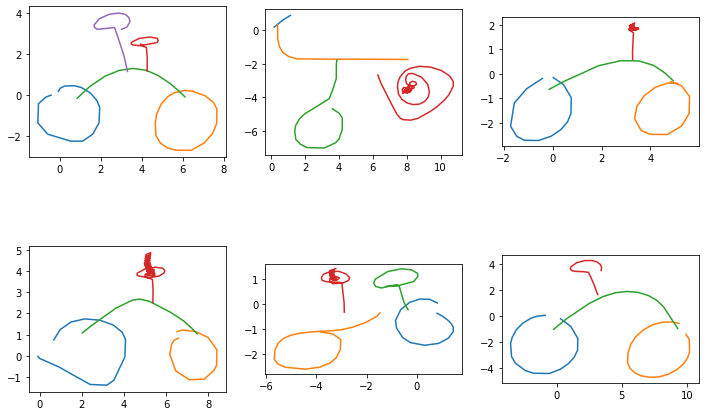

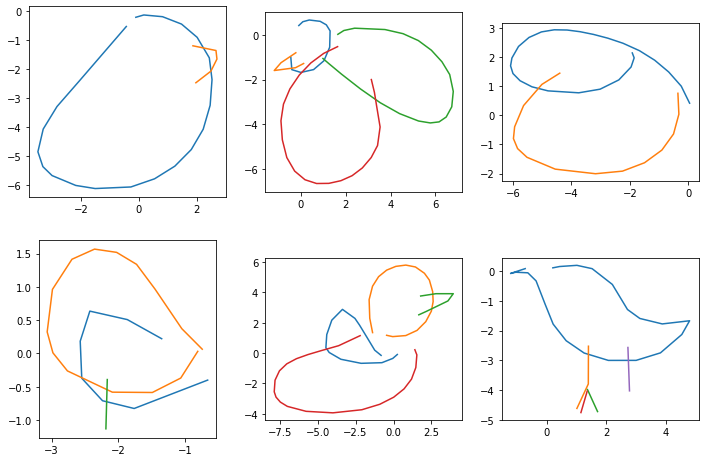

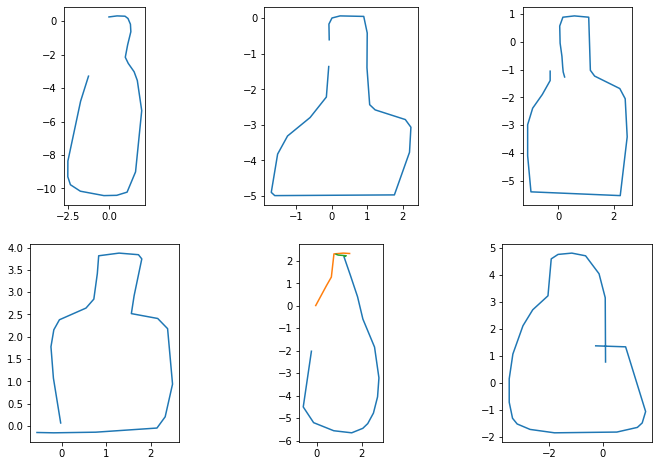

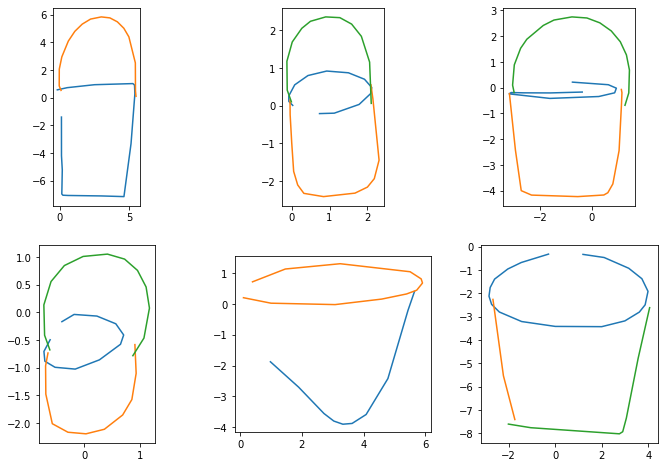

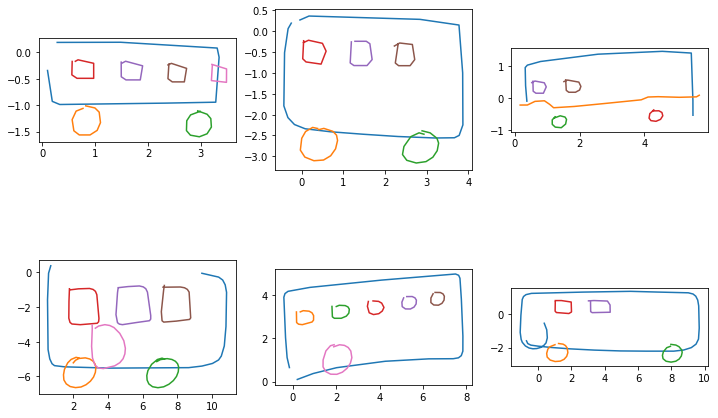

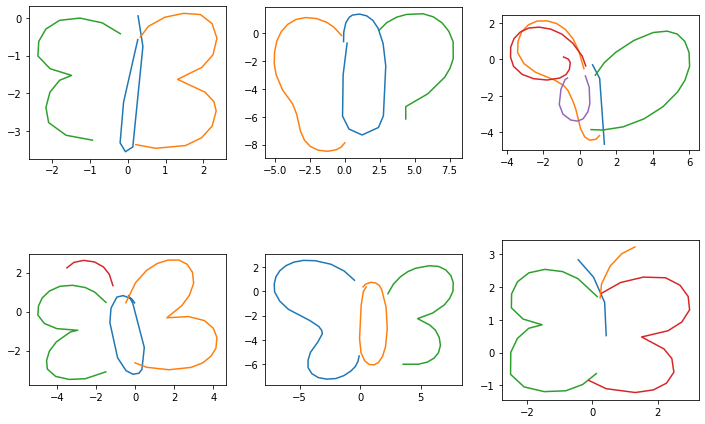

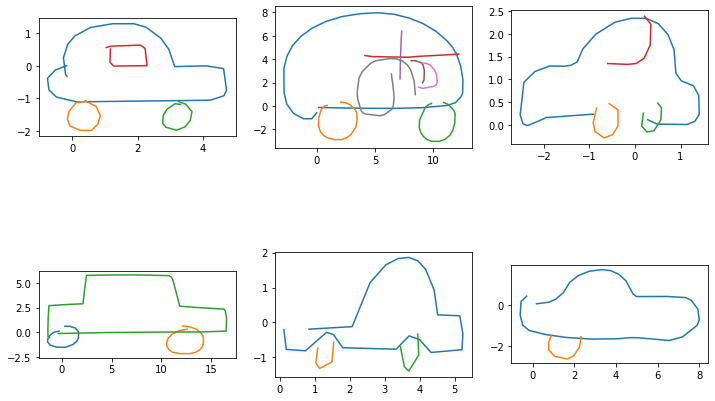

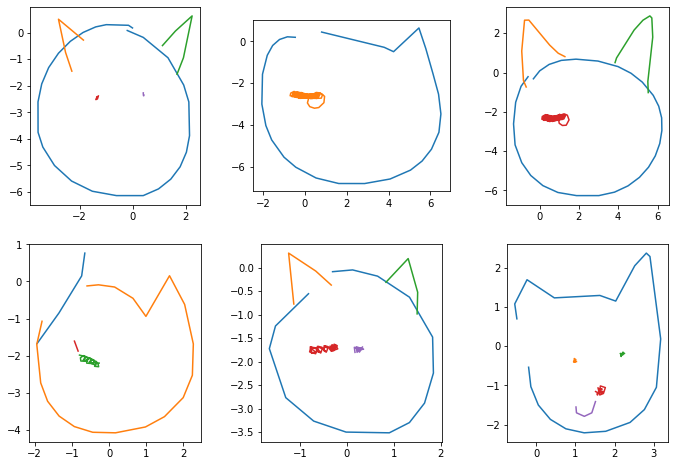

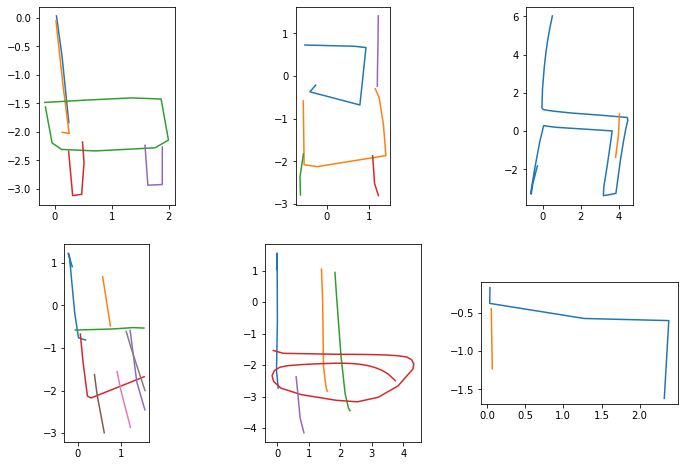

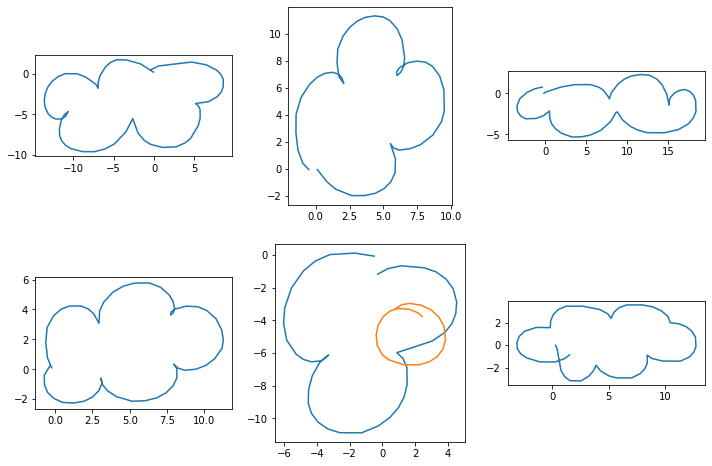

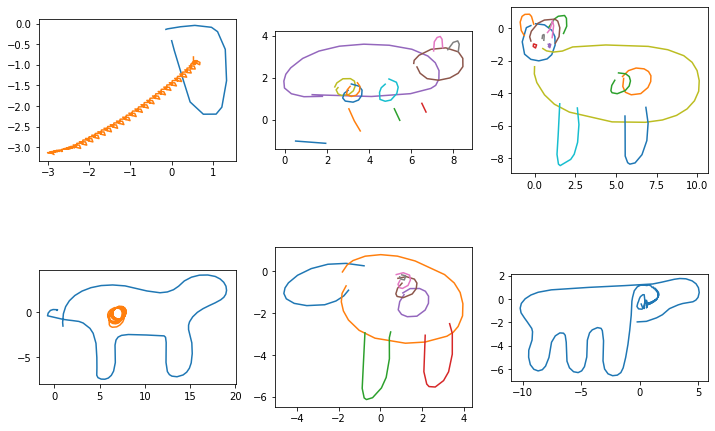

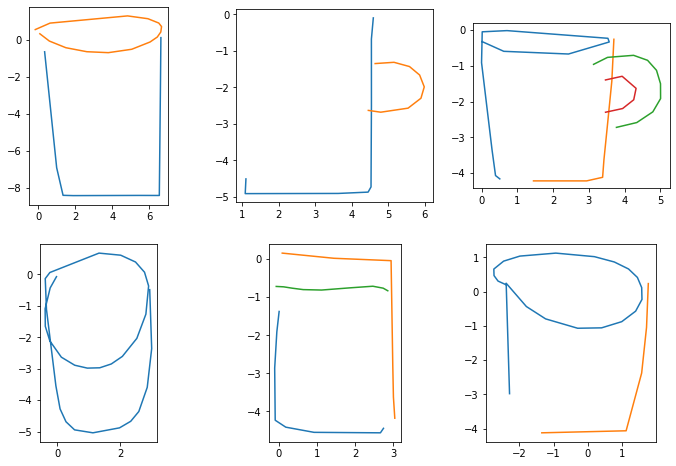

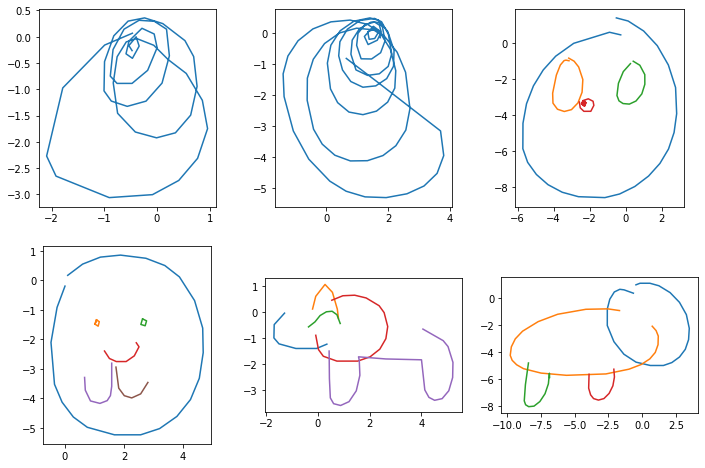

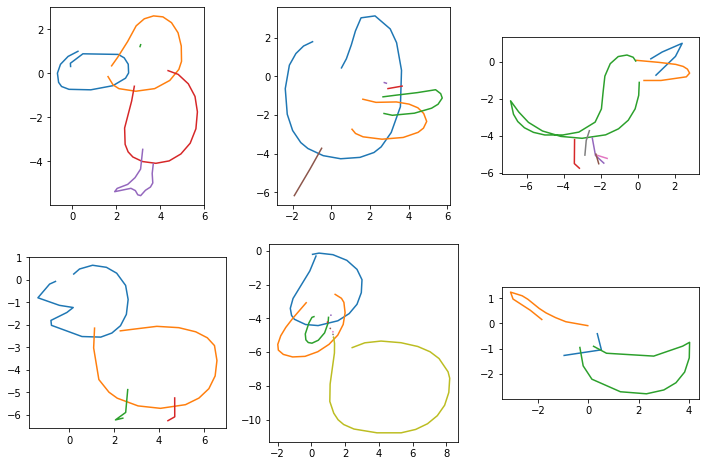

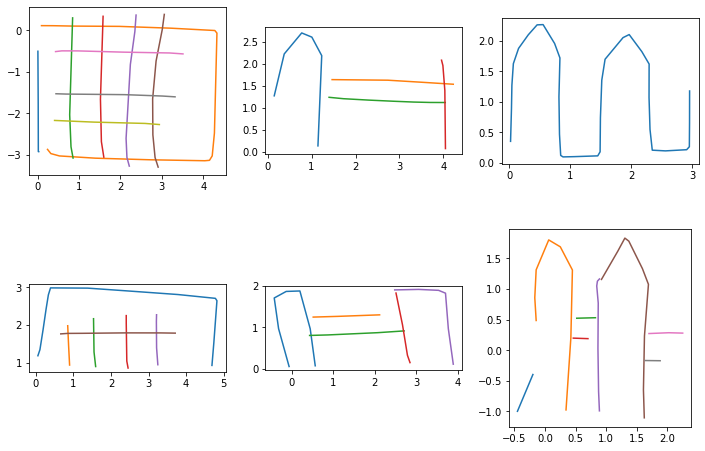

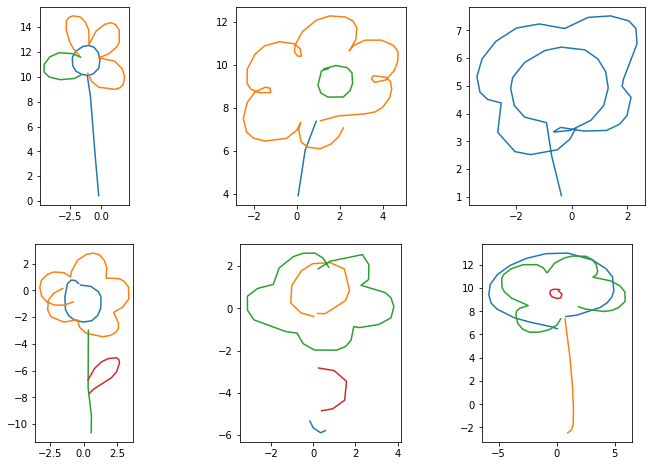

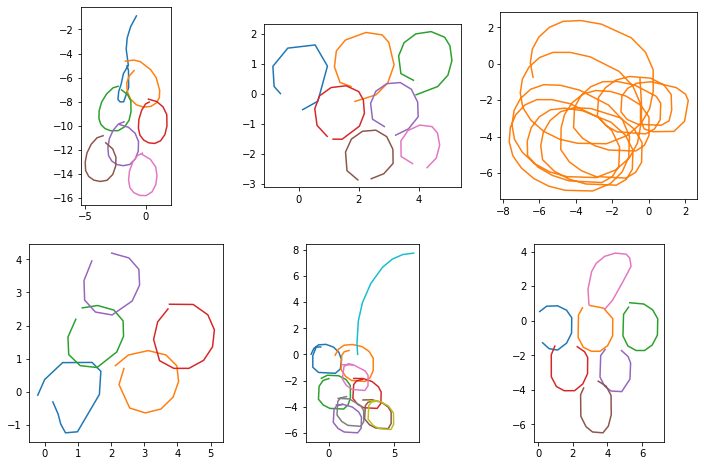

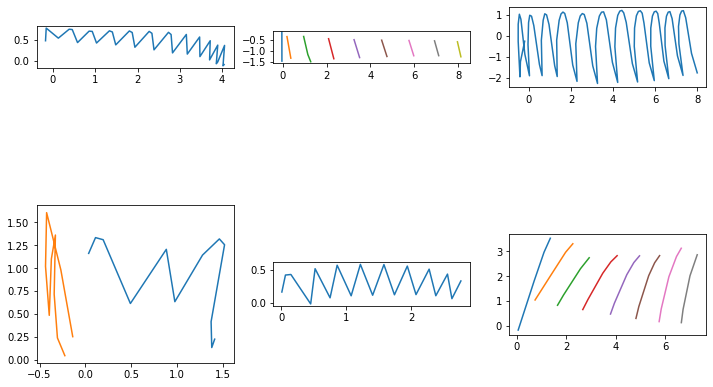

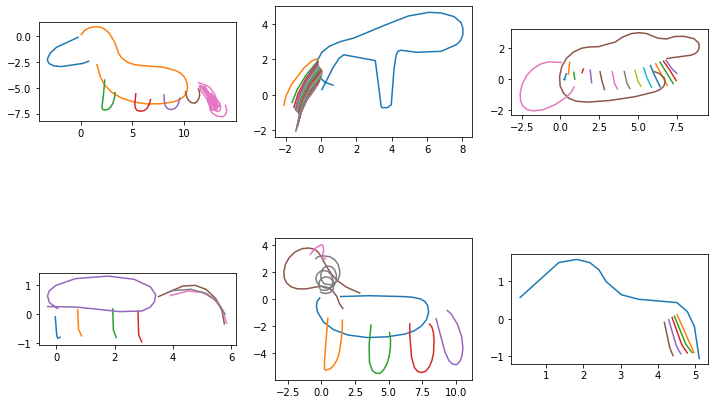

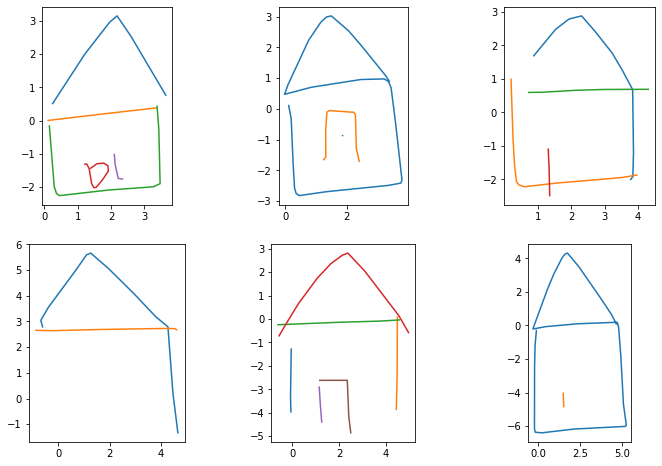

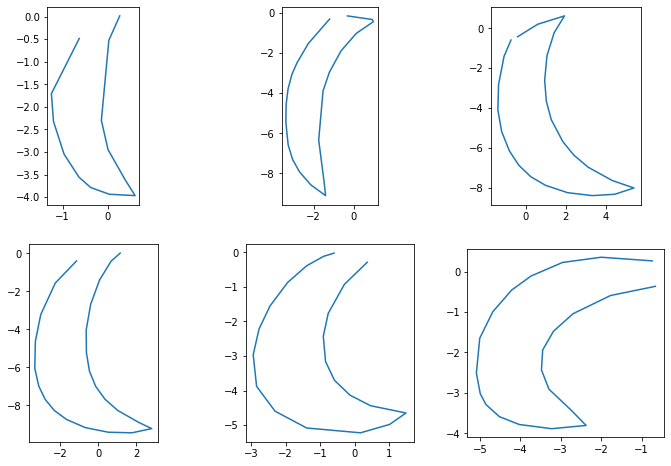

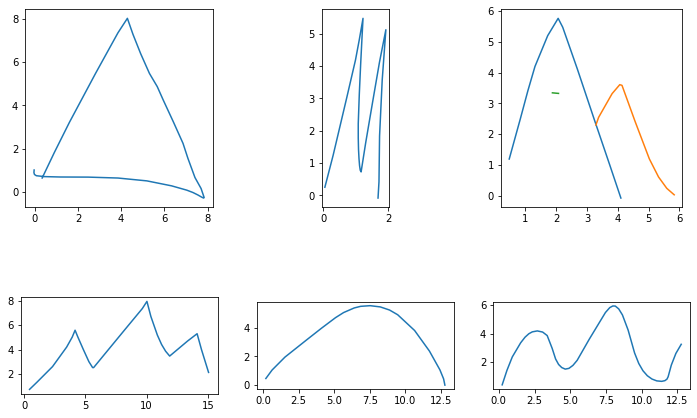

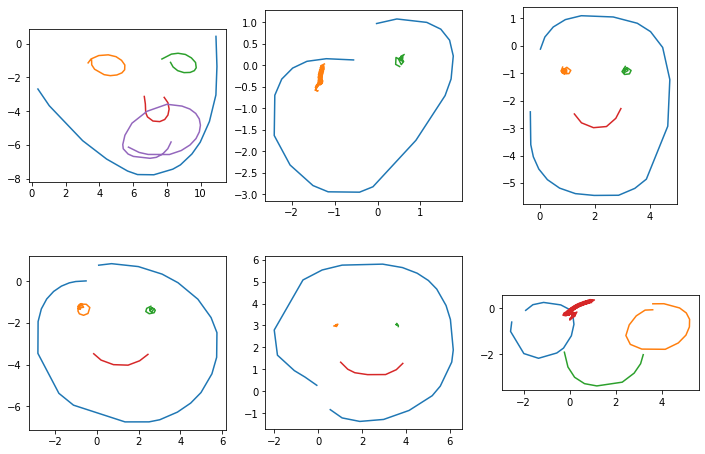

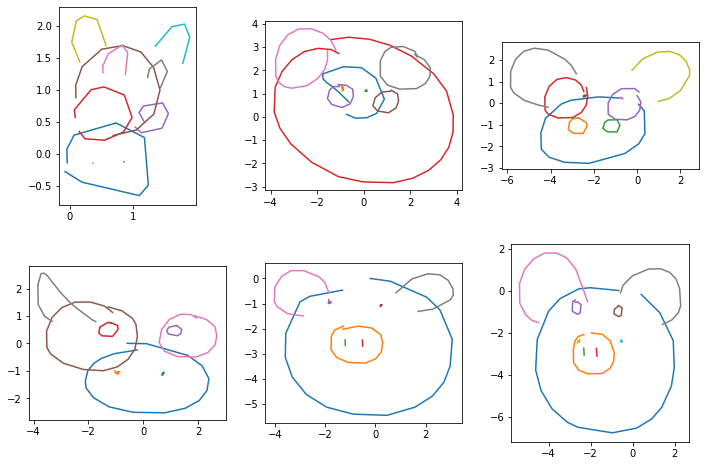

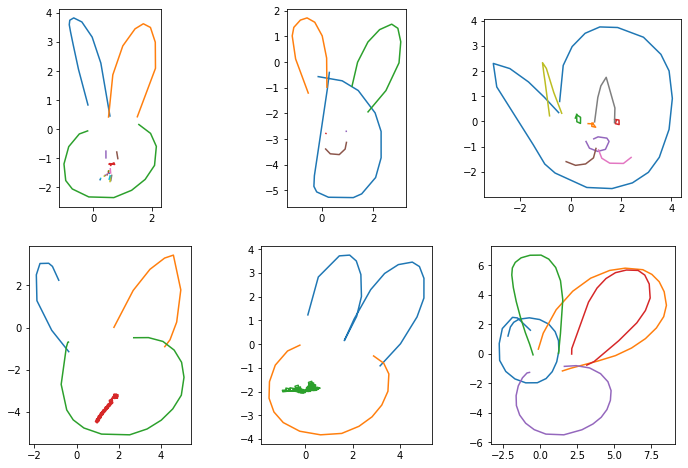

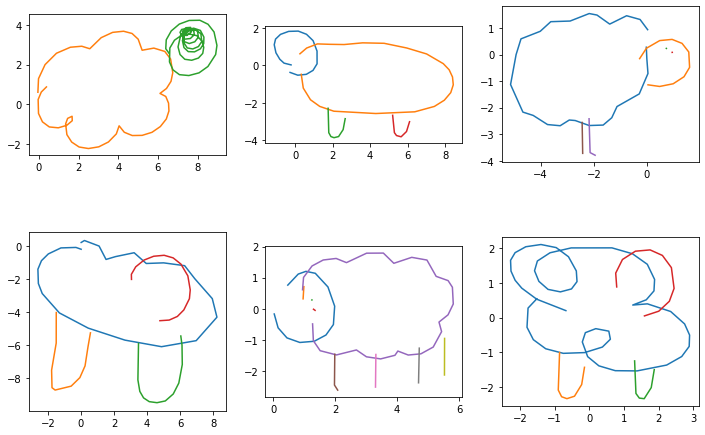

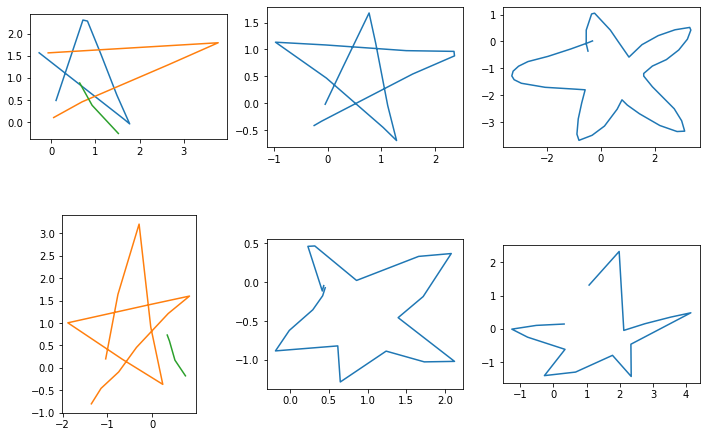

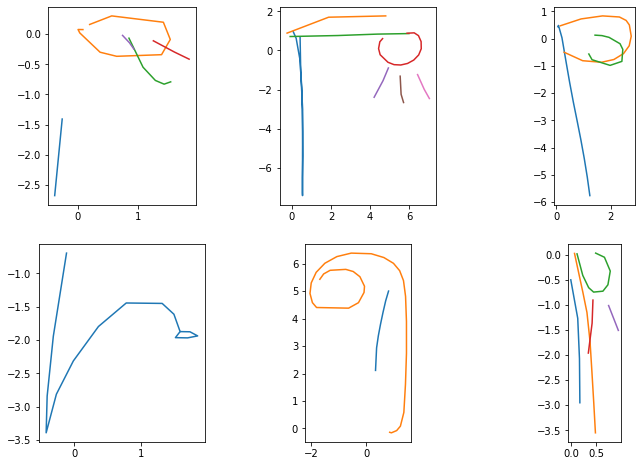

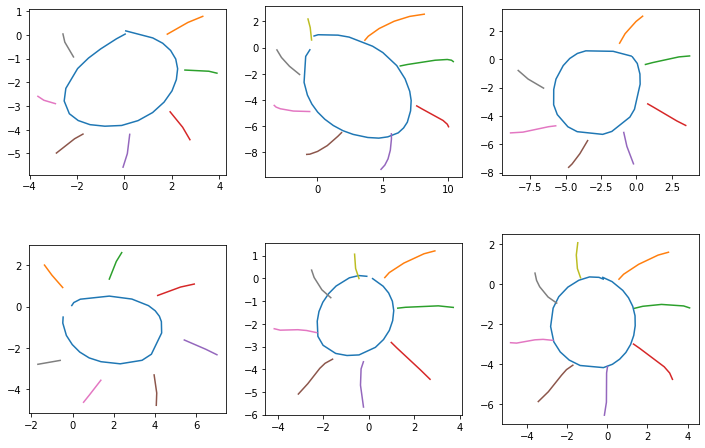

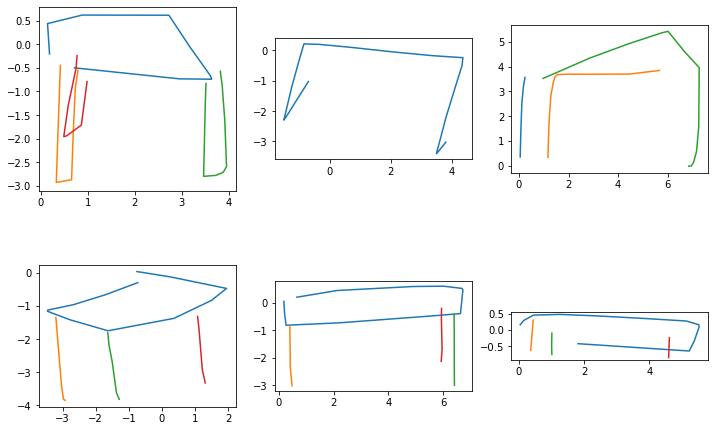

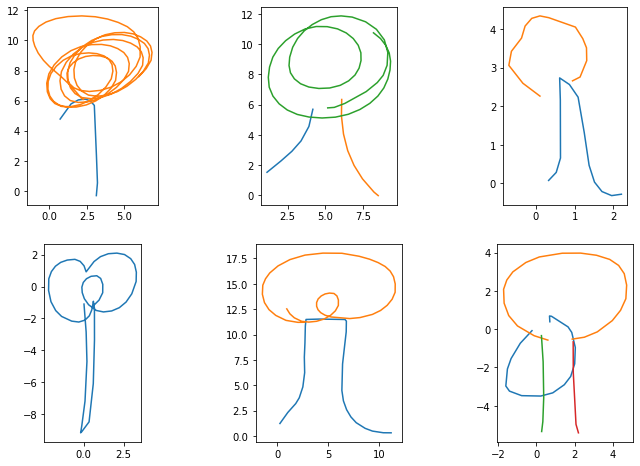

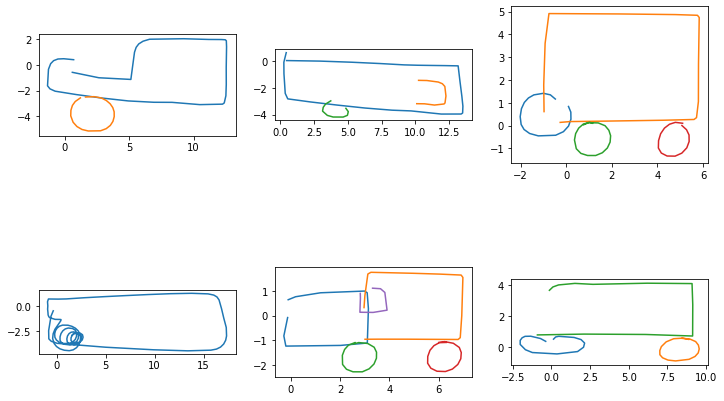

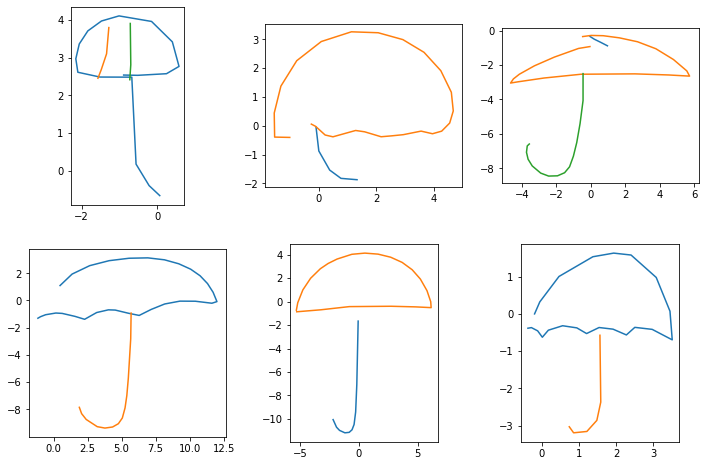

In [6]:
%matplotlib inline

N = 6
for data_class in classes:

    data = np.load(
        f'../data/quickdraw/{data_class}.npz', encoding='latin1', allow_pickle=True)

    data_train = [dataset.cleanup(d) for d in data['train']]
    data_valid = [dataset.cleanup(d) for d in data['valid']]
    data_test = [dataset.cleanup(d) for d in data['test']]

    hps = {
        "max_seq_len": max(map(len, np.concatenate([data['train'], data['valid'], data['test']]))),
        'batch_size': 100,
        "num_batches": math.ceil(len(data_train) / 100),
        "epochs": 100,
        "recurrent_dropout_prob": 0.1,  # 0.0 for gpu lstm
        "enc_rnn_size": 256,
        "dec_rnn_size": 512,
        "z_size": 128,
        "num_mixture": 20,
        "learning_rate": 0.001,
        "min_learning_rate": 0.00001,
        "decay_rate": 0.9999,
        "grad_clip": 1.0,
        'kl_tolerance': 0.2,
        'kl_decay_rate': 0.99995,
        "kl_weight": 0.5,
        'kl_weight_start': 0.01,
    }

    sketchrnn = models.SketchRNN(hps)
    # sketchrnn.models['full'].summary()

    weight_file = sorted(
        glob.glob(f'../data/sketchrnn/{data_class}/checkpoints/*.hdf5'))[-1]
    checkpoint = os.path.join(weight_file)
    sketchrnn.load_weights(checkpoint)

    print("data class:", data_class)
    fig = plt.figure(figsize=(12, 8))

    for i in range(1, N+1):
        strokes = to_normal_strokes(sketchrnn.sample(temperature=0.01))

        ax = fig.add_subplot(2, 3, i)
        X, Y = strokes_to_lines(strokes)
        for x, y in zip(X, Y):
            ax.plot(x, y)
        ax.set_aspect('equal')

    fig.show()
